In [1]:
import numpy as np
import scipy as sp
import random
import json
import matplotlib
import matplotlib.pyplot as pl
from mpl_toolkits.mplot3d import Axes3D
import GPy
from elfi.bo.gpy_model import GPyModel
from elfi.posteriors import BolfiPosterior
import matplotlib.gridspec as gridspec
from matplotlib import rc
%matplotlib inline

In [2]:
class Prior():

    def __init__(self, minval, maxval):
        self.minval = minval
        self.maxval = maxval

    def isValid():
        if self.minval > self.maxval:
            raise ValueError("Prior minval (%.2f) can't be larger than maxval (%.2f)" % (self.minval, self.maxval))
        return True

    def getProbDensity(self, value):
        raise NotImplementedError("Subclass implements")

    def getLogProbDensity(self, value):
        raise NotImplementedError("Subclass implements")

    def getRandomValue(self):
        raise NotImplementedError("Subclass implements")


class UniformPrior(Prior):
    """ Uniform distribution over the half-open interval [minval, maxval) """

    def isValid():
        if self.minval > self.maxval:
            raise ValueError("Prior minval (%.2f) can't be larger than maxval (%.2f)" % (self.minval, self.maxval))
        return True

    def getProbDensity(self, value):
        return 1.0 / (self.maxval - self.minval)

    def getLogProbDensity(self, value):
        return np.log(1.0) - np.log(self.maxval - self.minval)

    def getRandomValue(self):
        return np.random.uniform(self.minval, self.maxval)


class ClippedNormalPrior(Prior):
    """ Normal distribution truncated to interval [minval, maxval] """

    def __init__(self, minval, maxval, mean, std):
        super(ClippedNormalPrior, self).__init__(minval, maxval)
        self.mean = mean
        self.std = std

    def isValid():
        if self.minval > self.maxval:
            raise ValueError("Prior minval (%.2f) can't be larger than maxval (%.2f)" % (self.minval, self.maxval))
        if self.std <= 0.0:
            raise ValueError("Prior std (%.2f) must be positive" % (self.std))
        return True

    def getProbDensity(self, value):
        a, b = (self.minval - self.mean) / self.std, (self.maxval - self.mean) / self.std
        return sp.stats.truncnorm.pdf(value, a, b, self.mean, self.std)

    def getLogProbDensity(self, value):
        a, b = (self.minval - self.mean) / self.std, (self.maxval - self.mean) / self.std
        return sp.stats.truncnorm.logpdf(value, a, b, self.mean, self.std)

    def getRandomValue(self):
        a, b = (self.minval - self.mean) / self.std, (self.maxval - self.mean) / self.std
        return sp.stats.truncnorm.rvs(a, b, self.mean, self.std)
    
def plot_2d_mesh(X, Y, Z, ax):
    """
        Plot 2D mesh data with 'nlevels' contours.
        http://stackoverflow.com/questions/5127668/how-to-visualize-scalar-2d-data-with-matplotlib
    """
    return ax.contourf(X, Y, Z, cmap='hot')
    
def plot_3d_mesh(X, Y, Z, fig):
    ax = fig.gca(projection='3d')
    surf = ax.plot_surface(X, Y, Z, cmap='hot', alpha=1.0, antialiased=True, cstride=1, rstride=1, linewidth=0)
    cset = ax.contourf(X, Y, Z, zdir='z', offset=-1, cmap='hot')
    ax.set_zlim(-1, np.max(Z))
    fig.colorbar(surf, shrink=0.5, aspect=5)
    pl.show()
    
def eval_2d_mesh(xmin, ymin, xmax, ymax, nx, ny, eval_fun):
    """
        Evaluate 'eval_fun' at a grid defined by max and min
        values with number of points defined by 'nx' and 'ny'.
    """
    if xmin > xmax:
        raise ValueError("xmin (%.2f) was greater than"
                         "xmax (%.2f)" % (xmin, xmax))
    if ymin > ymax:
        raise ValueError("ymin (%.2f) was greater than"
                         "ymax (%.2f)" % (xmin, xmax))
    if nx < 1 or ny < 1:
        raise ValueError("nx (%.2f) or ny (%.2f) was less than 1" % (nx, ny))
    X = np.linspace(xmin, xmax, nx)
    lenx = len(X)
    Y = np.linspace(ymin, ymax, ny)
    leny = len(Y)
    X, Y = np.meshgrid(X, Y)
    Z = np.zeros((leny, lenx))
    for i in range(leny):
        for j in range(lenx):
            Z[i][j] = eval_fun([X[i][j], Y[i][j]])
    return (X, Y, Z)

In [3]:
with open("../results/menu/md5_f01_i23/samples.json") as f:
    md5_f01_i23 = json.load(f)
with open("../results/menu/md5_f02_i13/samples.json") as f:
    md5_f02_i13 = json.load(f)
with open("../results/menu/md5_f03_i12/samples.json") as f:
    md5_f03_i12 = json.load(f)
with open("../results/menu/md5_f12_i03/samples.json") as f:
    md5_f12_i03 = json.load(f)
with open("../results/menu/md5_f13_i02/samples.json") as f:
    md5_f13_i02 = json.load(f)
with open("../results/menu/md5_f23_i01/samples.json") as f:
    md5_f23_i01 = json.load(f)

prec psem (320, 2) (320, 1)


elfi.posteriors - INFO - Using minimum value of discrepancy estimate mean (0.1886) as threshold


dsel psem (400, 2) (400, 1)


elfi.posteriors - INFO - Using minimum value of discrepancy estimate mean (0.0918) as threshold


dsel prec (235, 2) (235, 1)


elfi.posteriors - INFO - Using minimum value of discrepancy estimate mean (0.0458) as threshold


fdur psem (400, 2) (400, 1)


elfi.posteriors - INFO - Using minimum value of discrepancy estimate mean (-0.0024) as threshold


fdur prec (397, 2) (397, 1)


elfi.posteriors - INFO - Using minimum value of discrepancy estimate mean (0.0001) as threshold


fdur dsel (400, 2) (400, 1)


elfi.posteriors - INFO - Using minimum value of discrepancy estimate mean (-0.0019) as threshold
 /m/home/home2/20/akangasr/unix/.venv/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


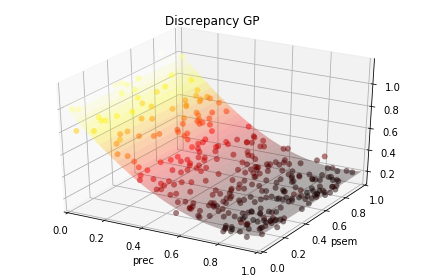

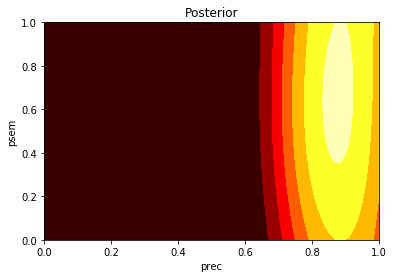

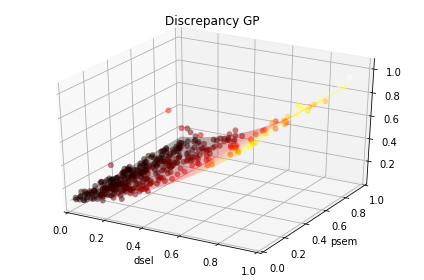

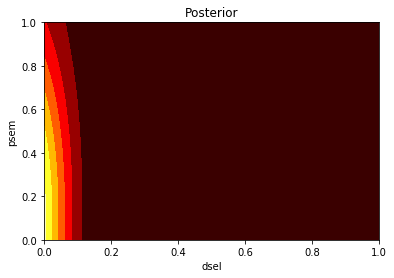

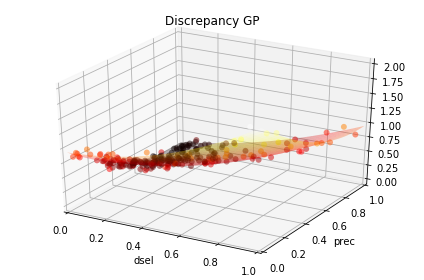

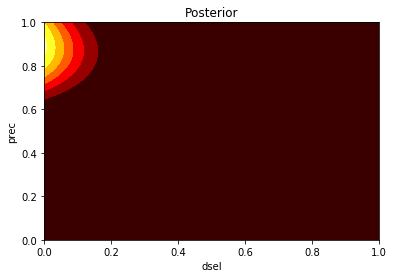

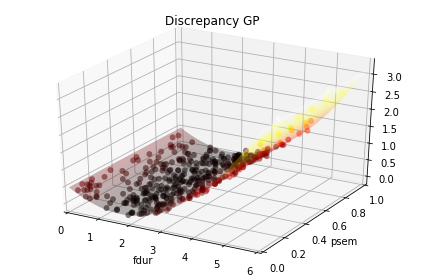

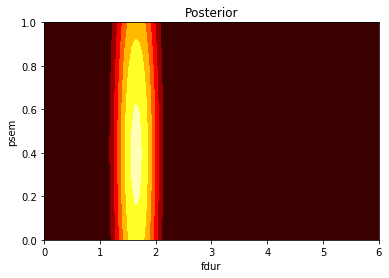

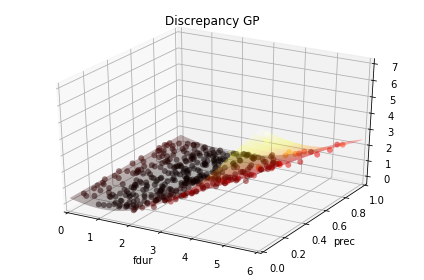

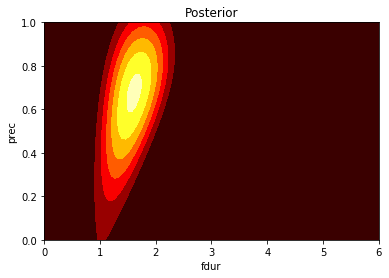

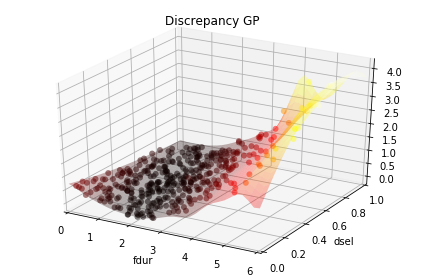

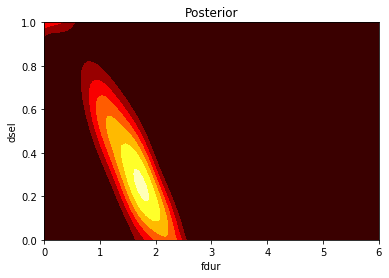

In [4]:
random.seed(0)
for i in range(6):
    params = [(ClippedNormalPrior(0, 6, 3, 1), (0,6), "fdur"),
              (ClippedNormalPrior(0, 1, 0.3, 0.3), (0,1), "dsel"),
              #(ClippedNormalPrior(0, 1, 0.69, 0.2), (0,1), "p_rec"),
              #(ClippedNormalPrior(0, 1, 0.93, 0.2), (0,1), "p_sem")]
              (UniformPrior(0, 1), (0,1), "prec"),
              (UniformPrior(0, 1), (0,1), "psem")]
    data, x_id, y_id = [(md5_f01_i23, 2, 3),
                        (md5_f02_i13, 1, 3),
                        (md5_f03_i12, 1, 2),
                        (md5_f12_i03, 0, 3),
                        (md5_f13_i02, 0, 2),
                        (md5_f23_i01, 0, 1)][i]
    priors = [params[x_id][0], params[y_id][0]]
    bounds = (params[x_id][1], params[y_id][1])
    name_x = params[x_id][2]
    name_y = params[y_id][2]
    X = list()
    Y = list()
    for y, x in data:
        X.append(x)
        Y.append(y)
    X = np.atleast_2d(X)
    Y = np.atleast_2d(Y).T
    print(name_x, name_y, X.shape, Y.shape)

    gp = GPyModel(
                  input_dim=X.shape[1],
                  bounds=bounds,
                  kernel_class=GPy.kern.RBF,
                  kernel_var=10.0,
                  kernel_scale=0.2,
                  noise_var=0.5,
                  max_opt_iters=100
                 )
    gp.update(X, Y)
    gp.gp.plot(plot_limits=[[bounds[0][0], bounds[1][0]], [bounds[0][1], bounds[1][1]]],
               projection="3d", legend=0)
    #pl.gca().legend().set_visible(False)
    pl.title("Discrepancy GP")
    pl.xlabel(name_x)
    pl.ylabel(name_y)

    fig = pl.figure()
    pl.title("Posterior")
    pl.xlabel(name_x)
    pl.ylabel(name_y)
    post = BolfiPosterior(model=gp, threshold=None, priors=priors)
    vals = eval_2d_mesh(bounds[0][0], bounds[1][0], bounds[0][1], bounds[1][1], 100, 100, post.pdf)
    pl.contourf(vals[0], vals[1], vals[2], cmap='hot')

(320, 2) (320, 1)


elfi.posteriors - INFO - Using minimum value of discrepancy estimate mean (0.0007) as threshold


(320, 2) (320, 1)


elfi.posteriors - INFO - Using minimum value of discrepancy estimate mean (0.0007) as threshold


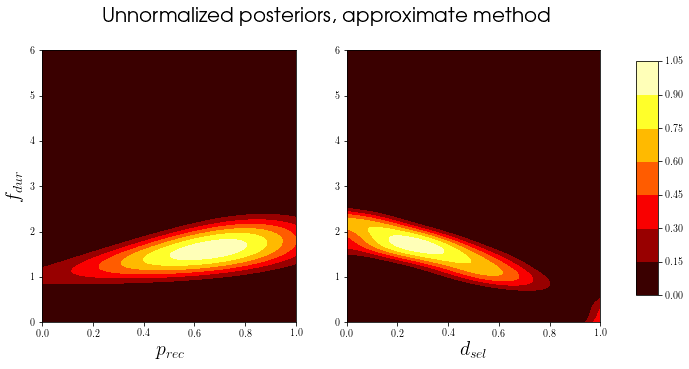

In [13]:
random.seed(0)
fig, axarr = pl.subplots(1, 2, figsize=(10,5))
pl.rc('text', usetex=True)
pl.rc('font', **{'family':'sans-serif','sans-serif':['Avant Garde']})
pl.suptitle(r"Unnormalized posteriors, approximate method", fontsize=20, x=0.52, y=1.0)
j = 0
for i in [4,5]:
    params = [(ClippedNormalPrior(0, 6, 3, 1), (0,6), r"$f_{dur}$"),
              (ClippedNormalPrior(0, 1, 0.3, 0.3), (0,1), r"$d_{sel}$"),
              #(ClippedNormalPrior(0, 1, 0.69, 0.2), (0,1), "p_rec"),
              #(ClippedNormalPrior(0, 1, 0.93, 0.2), (0,1), "p_sem")]
              (UniformPrior(0, 1), (0,1), r"$p_{rec}$"),
              (UniformPrior(0, 1), (0,1), r"$p_{sem}$")]
    data, x_id, y_id = [(md5_f01_i23, 2, 3),
                        (md5_f02_i13, 1, 3),
                        (md5_f03_i12, 1, 2),
                        (md5_f12_i03, 0, 3),
                        (md5_f13_i02, 0, 2),
                        (md5_f23_i01, 0, 1)][i]
    priors = [params[y_id][0], params[x_id][0]]
    bounds = (params[y_id][1], params[x_id][1])
    name_x = params[y_id][2]
    name_y = params[x_id][2]
    X = list()
    Y = list()
    for y, x in data:
        X.append([x[1], x[0]])
        Y.append(y)
    X = np.atleast_2d(X[:320])
    Y = np.atleast_2d(Y[:320]).T
    print(X.shape, Y.shape)

    gp = GPyModel(
                  input_dim=X.shape[1],
                  bounds=bounds,
                  kernel_class=GPy.kern.RBF,
                  kernel_var=10.0,
                  kernel_scale=0.2,
                  noise_var=0.5,
                  max_opt_iters=100
                 )
    gp.update(X, Y)

    ax = axarr[j]
    ax.set_xlabel(name_x, fontsize=20)
    if j == 0:
        ax.set_ylabel(name_y, fontsize=20)
    post = BolfiPosterior(model=gp, threshold=None, priors=priors)
    vals = eval_2d_mesh(bounds[0][0], bounds[1][0], bounds[0][1], bounds[1][1], 150, 150, post.pdf)
    CS = ax.contourf(vals[0], vals[1], vals[2] / np.max(vals[2]), cmap='hot')
    j += 1
cbar_ax = fig.add_axes([0.95, 0.2, 0.03, 0.65]) # left, bottom, width, height
fig.colorbar(CS, cax=cbar_ax)
#pl.tight_layout()
pl.show()
fig.savefig('../results/menu_posteriors.png', bbox_inches='tight')

 /m/home/home2/20/akangasr/unix/.venv/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


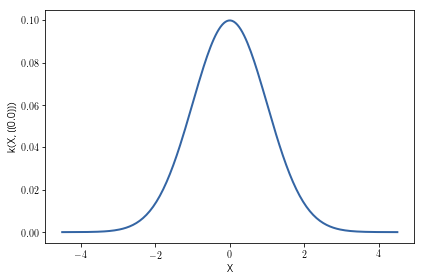

In [7]:
k1 = GPy.kern.RBF(input_dim=1, variance=0.1, lengthscale=1)
k1.plot()

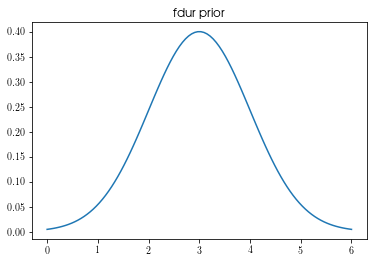

In [8]:
x = np.linspace(0, 6, 100)
pl.plot(x, sp.stats.truncnorm.pdf(x, -3, 3, 3, 1))
pl.title("fdur prior")
pl.show()

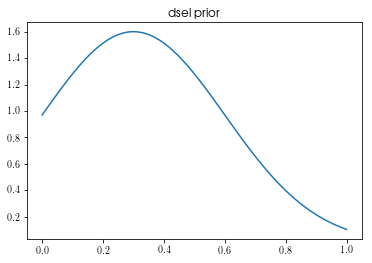

In [9]:
x = np.linspace(0, 1, 100)
pl.plot(x, sp.stats.truncnorm.pdf(x, -1, 0.7/0.3, 0.3, 0.3))
pl.title("dsel prior")
pl.show()

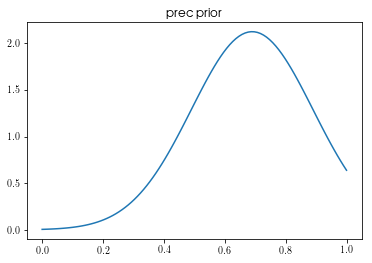

In [10]:
x = np.linspace(0, 1, 100)
pl.plot(x, sp.stats.truncnorm.pdf(x, -0.69/0.2, (1-0.69)/0.2, 0.69, 0.2))
pl.title("prec prior")
pl.show()

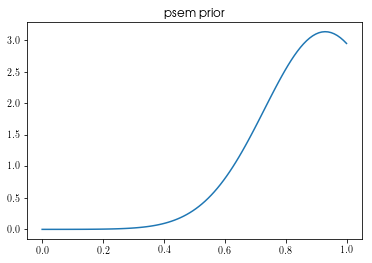

In [11]:
x = np.linspace(0, 1, 100)
pl.plot(x, sp.stats.truncnorm.pdf(x, -0.93/0.2, (1-0.93)/0.2, 0.93, 0.2))
pl.title("psem prior")
pl.show()